In [1]:
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from utils.data_loader import create_dataset
from utils.openmax import get_activations, compute_openmax
from utils.openmax_utils import get_openmax_predict, get_openmax_label, convert_to_binary_label, convert_to_label, compute_roc, plot_roc, compute_pr, plot_pr
from utils.graph import draw_confusion_matrix

2024-04-09 10:20:50.813753: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 10:20:50.813781: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 10:20:50.814365: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 10:20:50.817949: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-09 10:20:51.350157: W tensorflow/compiler/tf2

In [2]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


2024-04-09 10:20:52.083047: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 10:20:52.096770: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 10:20:52.096955: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_memory_growth(gpus[0], True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPU


2024-04-09 10:20:52.110233: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 10:20:52.110386: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-09 10:20:52.110496: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [4]:
SEED = 0
IMG_DIM = 299
BATCH_SIZE = 16
FOLD = 5

In [5]:
DATA_CSV = f'data/datasplit_fold{FOLD}.csv'

In [6]:
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [7]:
df = pd.read_csv(DATA_CSV)

In [8]:
model = tf.keras.models.load_model(f'models/fold_{FOLD}.h5')

In [9]:
test_unknown_ds = create_dataset(df, BATCH_SIZE, 'test_unknown')
_, y_test_unknown = test_unknown_ds.get_all()

In [10]:
logits_test, softmax_test = get_activations(test_unknown_ds, model)

2024-04-09 10:20:58.648554: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


107/107 [==============================] - 9s 75ms/step


In [11]:
openmax = []
prob_u = []
for logits in logits_test:
    temp_openmax, temp_prob_u = compute_openmax(logits.reshape(1, -1), FOLD)
    openmax.append(temp_openmax)
    prob_u.append(temp_prob_u)

openmax = np.asarray(openmax)
prob_u = np.asarray(prob_u)

In [12]:
y_test_unknown_binary = convert_to_binary_label(y_test_unknown)

In [13]:
roc = compute_roc(y_test_unknown_binary, prob_u)

In [14]:
pr = compute_pr(y_test_unknown_binary, prob_u)

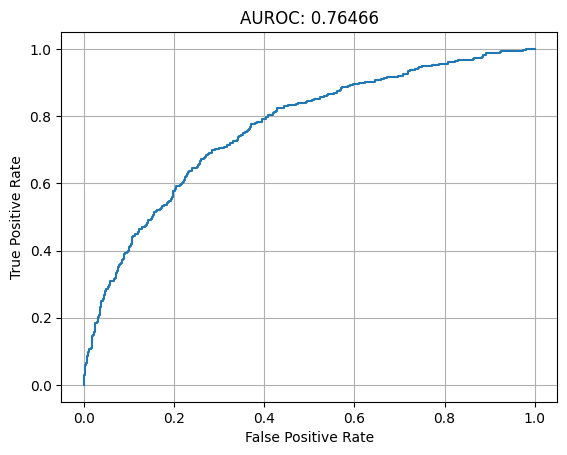

In [15]:
plot_roc(roc)

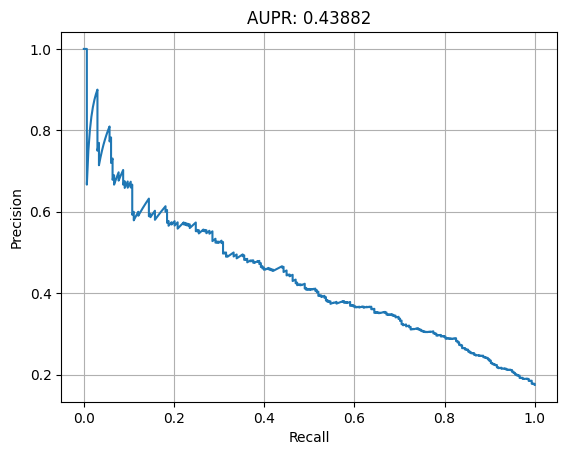

In [16]:
plot_pr(pr)

In [17]:
roc_thresholds = roc['thresholds']
np.savetxt('roc_thresholds.csv', roc_thresholds, delimiter=',')

In [18]:
pr_thresholds = pr['thresholds']
np.savetxt('pr_thresholds.csv', pr_thresholds, delimiter=',')

In [19]:
y_test_unknown_label = convert_to_label(y_test_unknown)

In [20]:
precision_arr = []
recall_arr = []
f1_arr = []
accuracy_arr = []
for threshold in pr_thresholds:
    y_hat_test = []
    for probs in openmax:
        temp = get_openmax_label(probs, threshold=threshold)
        y_hat_test.append(temp)
    y_hat_test = np.asarray(y_hat_test)

    precision = precision_score(y_test_unknown_label, y_hat_test, average='macro')
    recall = recall_score(y_test_unknown_label, y_hat_test, average='macro')
    f1 = f1_score(y_test_unknown_label, y_hat_test, average='macro')
    accuracy = accuracy_score(y_test_unknown_label, y_hat_test)

    precision_arr.append(precision)
    recall_arr.append(recall)
    f1_arr.append(f1)
    accuracy_arr.append(accuracy)

/home/bit/Workpaces/pace-up/openmax-body-img/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bit/Workpaces/pace-up/openmax-body-img/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/bit/Workpaces/pace-up/openmax-body-img/.venv/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

In [21]:
best_idx = np.argmax(f1_arr)

In [22]:
precision_arr[best_idx]

0.7346478346168842

In [23]:
recall_arr[best_idx]

0.7799096217056235

In [24]:
f1_arr[best_idx]

0.7379585340449402

In [25]:
accuracy_arr[best_idx]

0.7667057444314185

In [26]:
# test_ds = create_dataset(df, BATCH_SIZE, 'test')
# x_test, y_test = test_ds.get_all()

In [27]:
# for i in range(5):
#     random_char = np.random.randint(0, len(x_test))

#     test_x1 = x_test[random_char]
#     test_y1 = y_test[random_char]

#     logits, softmax = get_activations(
#         test_x1.reshape(-1, IMG_DIM, IMG_DIM, 3), model)

#     openmax, _ = compute_openmax(logits, FOLD)

#     print(f'SoftMax Sum: {np.sum(softmax)}')
#     print(f'OpenMax Sum: {np.sum(openmax)}')
#     print(f'True Label: {np.argmax(test_y1)}')
#     print(f'SoftMax Label: {np.argmax(softmax)}')
#     print(f'OpenMax Label: {get_openmax_label(openmax, pr_thresholds[best_idx])}')
#     plt.imshow((test_x1+1)/2)
#     plt.show()

In [28]:
# y_hat = model.predict(test_ds)

In [29]:
# y_hat = np.argmax(y_hat, axis=1).astype(np.uint8)
# y_test = np.argmax(y_test, axis=1).astype(np.uint8)

In [30]:
# cm = confusion_matrix(y_test, y_hat, normalize='true')
# cm = np.round(cm, 2)

In [31]:
# class_name = range(test_ds.get_class_num())

In [32]:
# draw_confusion_matrix(cm, class_name)